In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

In [7]:
df = read_csv_replace_missing_by_polynomial('pib_pernambuco.csv', 0, 0)
df.head(len(df))

,Ano,Pernambuco - PIB - Estadual,Pernambuco - PIB - Construção Civil,Pernambuco - PIB - Per Capita,Pernambuco - PIB - Preços de Mercado
0,1985,2.187938e+07,5.595574e+06,7.450716,5.773147e+07
1,1986,2.506986e+07,5.718883e+06,7.586767,5.947855e+07
2,1987,2.853817e+07,5.835334e+06,7.718756,6.114894e+07
3,1988,3.241702e+07,5.990276e+06,7.838290,6.276030e+07
4,1989,3.658583e+07,6.152736e+06,7.962513,6.445813e+07
5,1990,4.102985e+07,6.220816e+06,8.106827,6.625840e+07
6,1991,4.536854e+07,6.289642e+06,8.195801,6.759234e+07
7,1992,4.986928e+07,6.289619e+06,8.261644,6.872813e+07
8,1993,5.460610e+07,6.254807e+06,8.321253,6.982415e+07
9,1994,5.928722e+07,6.155123e+06,8.389430,7.091108e+07


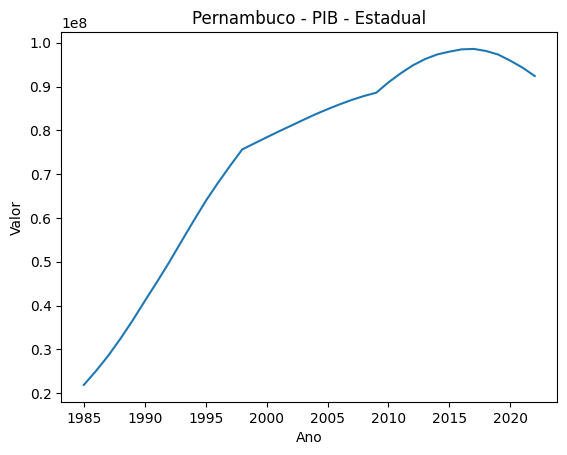

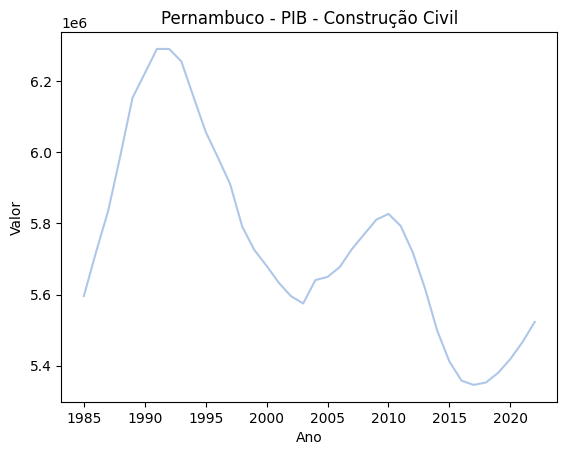

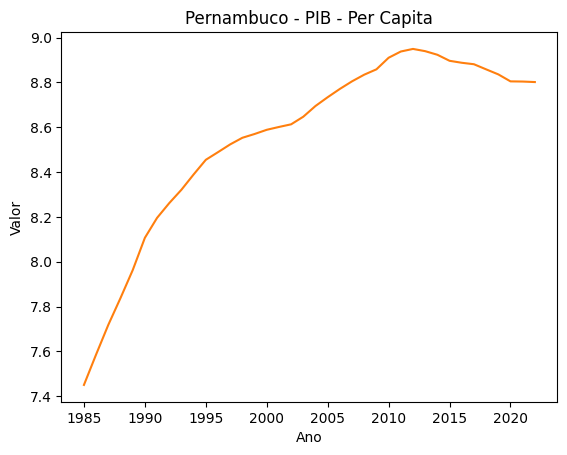

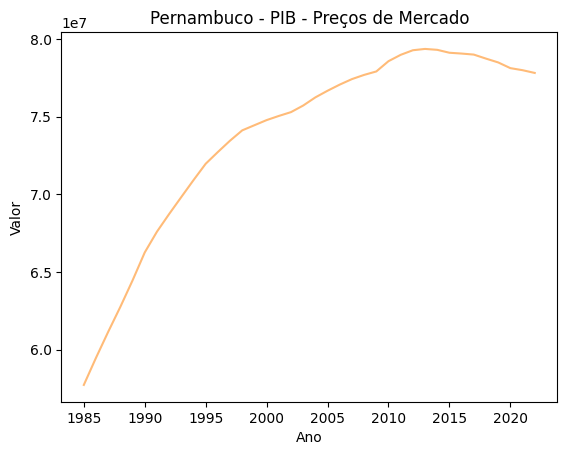

,Pernambuco - PIB - Estadual,Pernambuco - PIB - Construção Civil,Pernambuco - PIB - Per Capita,Pernambuco - PIB - Preços de Mercado
Ano,,,,
1985,2.187938e+07,5.595574e+06,7.450716,5.773147e+07
1986,2.506986e+07,5.718883e+06,7.586767,5.947855e+07
1987,2.853817e+07,5.835334e+06,7.718756,6.114894e+07
1988,3.241702e+07,5.990276e+06,7.838290,6.276030e+07
1989,3.658583e+07,6.152736e+06,7.962513,6.445813e+07
1990,4.102985e+07,6.220816e+06,8.106827,6.625840e+07
1991,4.536854e+07,6.289642e+06,8.195801,6.759234e+07
1992,4.986928e+07,6.289619e+06,8.261644,6.872813e+07
1993,5.460610e+07,6.254807e+06,8.321253,6.982415e+07


In [10]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
plot_columns(df_year)
df_year

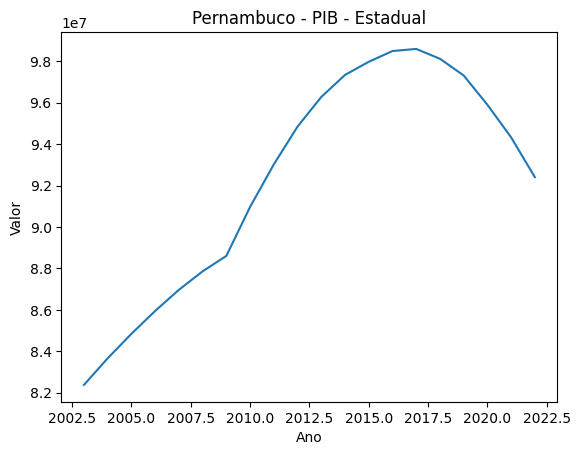

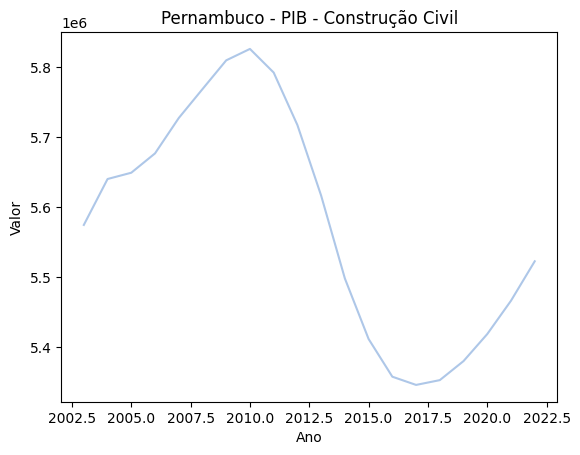

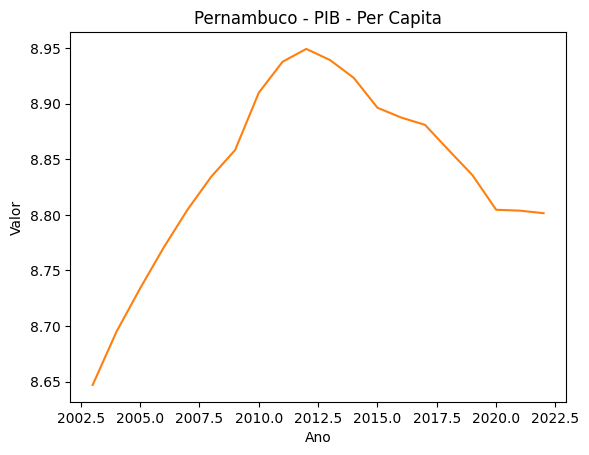

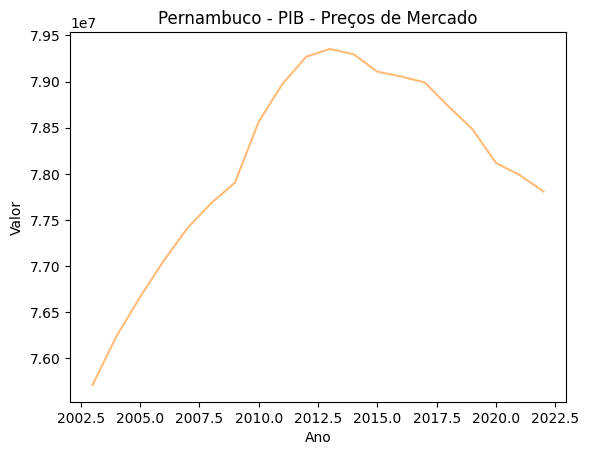

,Pernambuco - PIB - Estadual,Pernambuco - PIB - Construção Civil,Pernambuco - PIB - Per Capita,Pernambuco - PIB - Preços de Mercado
Ano,,,,
2003,8.237381e+07,5.574893e+06,8.646979,7.571061e+07
2004,8.366033e+07,5.640541e+06,8.694752,7.623567e+07
2005,8.484033e+07,5.649536e+06,8.733906,7.666319e+07
2006,8.594487e+07,5.677153e+06,8.770881,7.705796e+07
2007,8.696379e+07,5.727693e+06,8.804784,7.741156e+07
2008,8.785657e+07,5.769035e+06,8.834432,7.768216e+07
2009,8.860216e+07,5.810149e+06,8.858245,7.790384e+07
2010,9.096526e+07,5.826469e+06,8.909890,7.856512e+07
2011,9.301827e+07,5.792701e+06,8.937706,7.897343e+07


In [11]:
df_2003 = df_year[df_year.index >= 2003]
plot_columns(df_2003)
df_2003

In [12]:
df_2003.to_csv('2003_01_pib.csv')

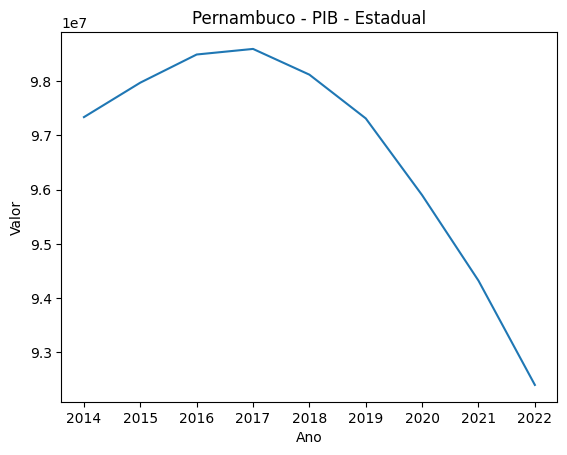

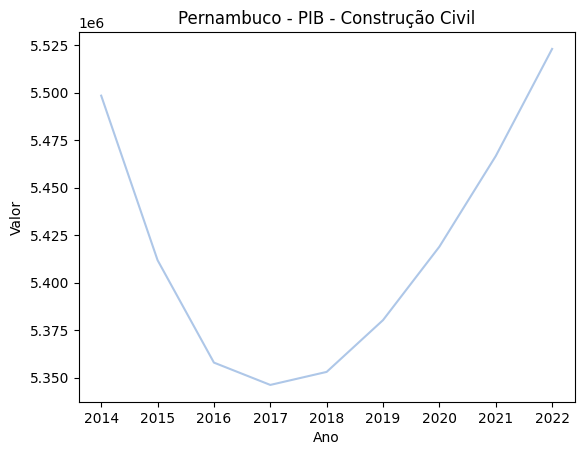

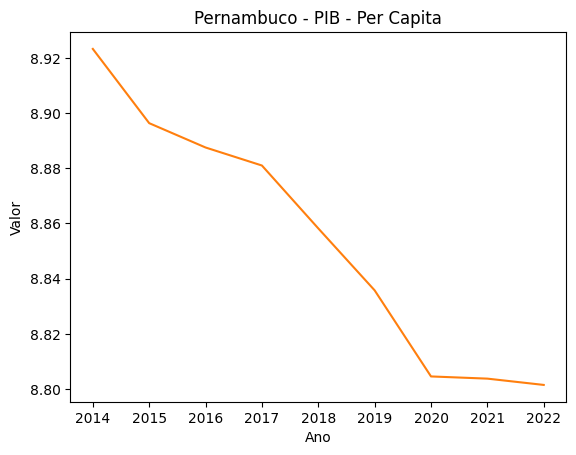

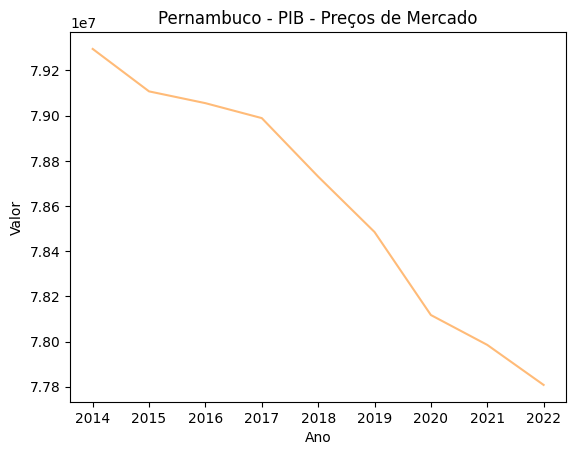

,Pernambuco - PIB - Estadual,Pernambuco - PIB - Construção Civil,Pernambuco - PIB - Per Capita,Pernambuco - PIB - Preços de Mercado
Ano,,,,
2014,9.733647e+07,5.498393e+06,8.923227,7.929548e+07
2015,9.797155e+07,5.411870e+06,8.896326,7.910750e+07
2016,9.849009e+07,5.357988e+06,8.887508,7.905537e+07
2017,9.859294e+07,5.346247e+06,8.880979,7.898921e+07
2018,9.811873e+07,5.353096e+06,8.858194,7.873031e+07
2019,9.731261e+07,5.380332e+06,8.835747,7.848506e+07
2020,9.589838e+07,5.418959e+06,8.804547,7.811752e+07
2021,9.432318e+07,5.466622e+06,8.803752,7.798536e+07
2022,9.240245e+07,5.522973e+06,8.801473,7.780811e+07


In [9]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [10]:
df_2014.to_csv('2014_01_pib.csv')